In [2]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#tensorflow objects
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, FullSpaceNNFormulation, \
FullSpaceSmoothNNFormulation, ReducedSpaceSmoothNNFormulation, ReluBigMFormulation,\
ReluComplementarityFormulation, ReluPartitionFormulation
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader
import omlt
from keras.layers import PReLU

from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pyomo.environ as pyo
import omlt
from omlt import OmltBlock
from omlt.neuralnet import *
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader
from tensorflow.keras import initializers

2023-06-13 15:34:59.376426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 15:34:59.505580: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 15:34:59.508430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-13 15:34:59.508446: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
alphas = [1.5, 1, 0.5, 0, -0.5, -1, -1.5]
leakynets = []

for alpha in alphas:
    model = Sequential(name=f'leakynet_{alpha}')
    model.add(Input(1))
    model.add(Dense(1, activation=LeakyReLU(alpha=alpha), kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.add(Dense(1, kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.compile(optimizer=Adam(), loss='mse')
    leakynets.append(model)

alphas = [1.5, 1, 0.5, 0, -0.5, -1, -1.5]
prelu_nets = []

for alpha in alphas:
    model = Sequential(name=f'prelu_net_{alpha}')
    model.add(Input(1))
    alpha_initializer = initializers.Constant(value=alpha)
    model.add(Dense(1, activation=PReLU(alpha_initializer=alpha_initializer, weights=None), kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    prelu_nets.append(model)

2023-06-13 15:35:04.652251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-13 15:35:04.652291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sherzoy-IdeaPad-5-14ITL05): /proc/driver/nvidia/version does not exist
2023-06-13 15:35:04.652741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Input data
inputs = np.array([1, 2, 3, 4, 5])

# Create empty arrays to store outputs
leaky_outputs = []
prelu_outputs = []

# Feed inputs to each neural network and store their outputs
for model in leakynets:
    outputs = model.predict(inputs)
    leaky_outputs.append(outputs.flatten())

for model in prelu_nets:
    outputs = model.predict(inputs)
    prelu_outputs.append(outputs.flatten())

1/1 [==============================] - 0s 38ms/step


In [5]:
print(prelu_nets[1].predict(x=inputs))

1/1 [==============================] - 0s 17ms/step
[[0.01349554]
 [0.03928937]
 [0.0650832 ]
 [0.09087702]
 [0.11667085]]


1/1 [==============================] - 0s 38ms/step
{0: (1.0, 5.0)}
WARNING (W1002): Setting Var 'nn.scaled_inputs[0]' to a numeric value `0`
    outside the bounds (1.0, 5.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[0]' to a numeric value `0`
    outside the bounds (1.0, 5.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
[<InputLayer(input_size=[1], output_size=[1]) at 0x7fe7b0552f10>, <DenseLayer(input_size=[1], output_size=[1]) at 0x7fe7b05522e0>, <DenseLayer(input_size=[1], output_size=[1]) at 0x7fe8189d9a90>]
0 -0.039587294682860374 -0.09941080771386623 nn.layer[140633072542432].zhat[0] nn.layer[140633072542432].qb[0] -1.5
ERROR: Rule failed when generating expression for Constraint
    nn.layer[140634822122128].dense_layer with index 0:
    InfeasibleConstraintException: Variable has a lower bound which is larger
    than its upper bound: nn.layer[140633072542432].z[0]
ERROR: Con

InfeasibleConstraintException: Variable has a lower bound which is larger than its upper bound: nn.layer[140633072542432].z[0]

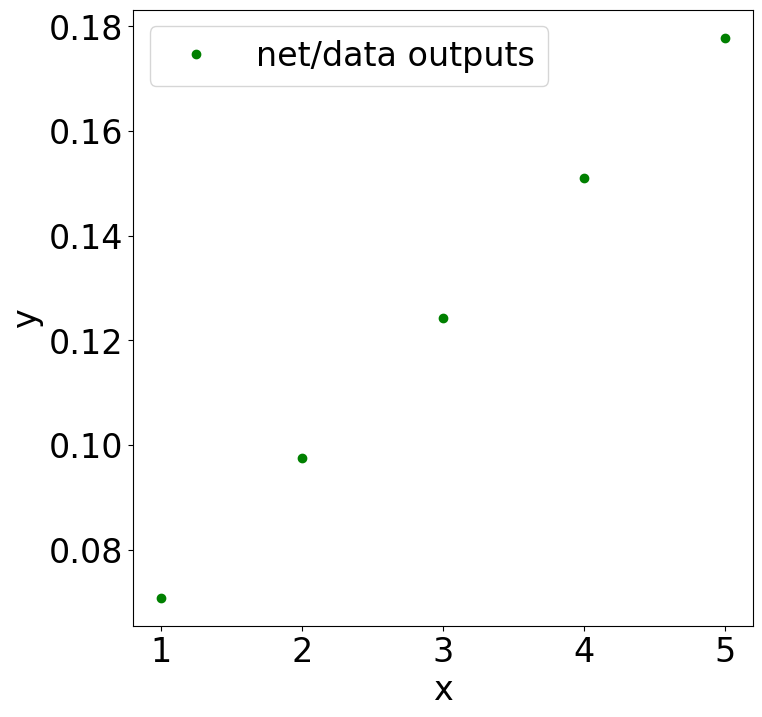

In [14]:
# function to evaluate a point on the neuralnet using OMLT
def OMLTcheck(net, inputs, outputs):

    # Create a dictionary with the field names and corresponding arrays
    data = {'x': inputs, 'y': outputs.flatten()}

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

    #retrieve input 'x' and output 'y' from the dataframe
    x = df["x"]
    y = df["y"]

    y_predict = net.predict(x=df['x'])

    #create a single plot with the original data and each neural network's predictions
    fig,ax = plt.subplots(1,figsize = (8,8))
    ax.plot(x, y_predict, linestyle='', marker='o', color='green', label='net/data outputs')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    #create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
    input_bounds={0:((min(df['x']) - 0)/1,
                 (max(df['x']) - 0)/1)}
    print(input_bounds)
    net_relu = keras_reader.load_keras_sequential(net, unscaled_input_bounds=input_bounds)

    model_bigm = pyo.ConcreteModel()
    model_bigm.x = pyo.Var(initialize =0)
    model_bigm.y = pyo.Var(initialize = 0)
    model_bigm.obj = pyo.Objective(expr=(model_bigm.y))
    model_bigm.nn = OmltBlock()

    formulation_bigm = ReluBigMFormulation(net_relu)
    model_bigm.nn.build_formulation(formulation_bigm)

    @model_bigm.Constraint()
    def connect_inputs(mdl):
        return mdl.x == mdl.nn.inputs[0]

    @model_bigm.Constraint()
    def connect_outputs(mdl):
        return mdl.y == mdl.nn.outputs[0]

    status_bigm = pyo.SolverFactory('gams:cbc').solve(model_bigm, tee=True)
    solution_bigm = (pyo.value(model_bigm.x),pyo.value(model_bigm.y))

    #print out model size and solution values
    print("ReLU BigM Solution:")
    print("# of variables: ",model_bigm.nvariables())
    print("# of constraints: ",model_bigm.nconstraints())
    print("x = ", solution_bigm[0])
    print("y = ", solution_bigm[1])

    #net - parametric relu 
    plt.title("OMLT vs Keras values")
    plt.scatter([solution_bigm[0]],[solution_bigm[1]],color = "blue",s = 300, label="OMLT sol")
    plt.legend()
    plt.show()
    plt.close()

n = 6
OMLTcheck(prelu_nets[n],inputs,prelu_outputs[n])

# OMLTcheck(leakynets[n],inputs,leaky_outputs[n])
#(0,5)


In [7]:
#OMLTcheck(prelu_nets[0],inputs,prelu_outputs[0])